In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
# # Transformação: converte para tensor e normaliza (média e desvio de MNIST)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

# # Dataset de treino e teste
# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Subset com os primeiros 1000 para treino e 500 para validação
# train_subset = Subset(train_dataset, range(1000))
# val_subset   = Subset(test_dataset, range(500))

# # DataLoaders
# train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
# val_loader   = DataLoader(val_subset, batch_size=64, shuffle=False)

In [86]:
# Transformação padrão para Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# Dataset Fashion-MNIST
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
full_val_dataset   = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Subsets reduzidos
train_subset = Subset(full_train_dataset, range(200))
val_subset   = Subset(full_val_dataset, range(200))

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=64, shuffle=False)

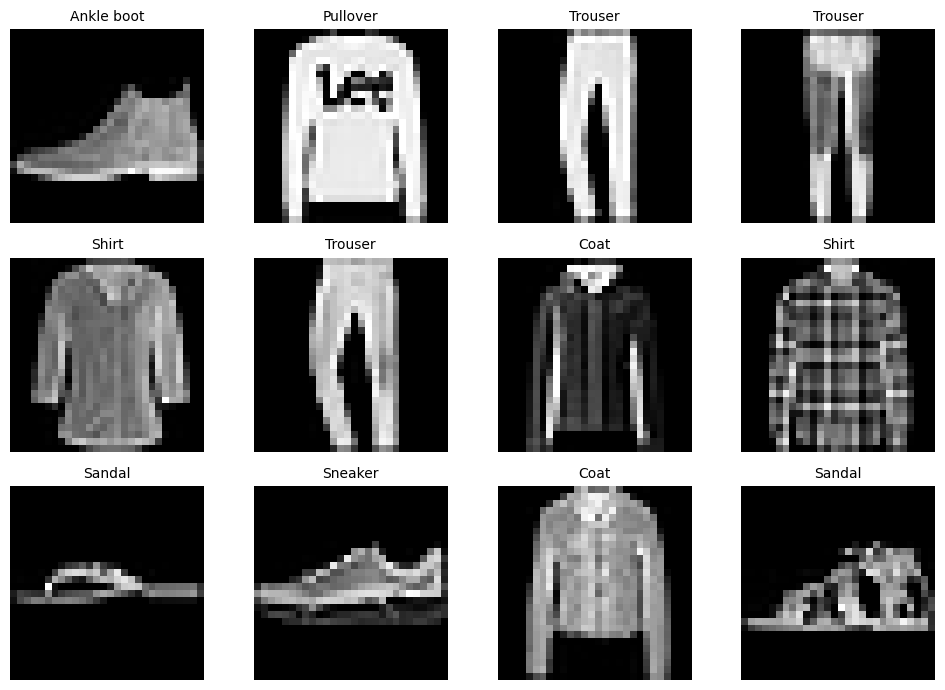

In [87]:
# Classe names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Mostrar 12 imagens
fig, axes = plt.subplots(3, 4, figsize=(10, 7))
for i, ax in enumerate(axes.flatten()):
    img, label = val_subset[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(class_names[label], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [88]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_training_history(history):
    epochs = range(1, len(history['train_losses']) + 1)
    
    plt.figure(figsize=(12, 5))

    # Losses
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.plot(epochs, history['train_losses'], label='Train Loss')
    plt.plot(epochs, history['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracies
    plt.subplot(1, 2, 2)
    plt.grid()
    plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [89]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

100%|██████████| 4/4 [00:00<00:00, 71.14it/s]


Epoch 1, Train Loss: 2.303, Train Accuracy: 7.00%
Epoch 1, Val Loss: 2.296, Val Accuracy: 8.50%


100%|██████████| 4/4 [00:00<00:00, 91.34it/s]


Epoch 2, Train Loss: 2.283, Train Accuracy: 10.00%
Epoch 2, Val Loss: 2.275, Val Accuracy: 27.00%


100%|██████████| 4/4 [00:00<00:00, 89.68it/s]


Epoch 3, Train Loss: 2.256, Train Accuracy: 27.50%
Epoch 3, Val Loss: 2.247, Val Accuracy: 29.00%


100%|██████████| 4/4 [00:00<00:00, 87.34it/s]


Epoch 4, Train Loss: 2.232, Train Accuracy: 24.50%
Epoch 4, Val Loss: 2.212, Val Accuracy: 24.00%


100%|██████████| 4/4 [00:00<00:00, 82.25it/s]


Epoch 5, Train Loss: 2.159, Train Accuracy: 23.50%
Epoch 5, Val Loss: 2.160, Val Accuracy: 26.50%


100%|██████████| 4/4 [00:00<00:00, 82.52it/s]


Epoch 6, Train Loss: 2.022, Train Accuracy: 25.00%
Epoch 6, Val Loss: 2.076, Val Accuracy: 25.00%


100%|██████████| 4/4 [00:00<00:00, 79.01it/s]


Epoch 7, Train Loss: 1.876, Train Accuracy: 23.50%
Epoch 7, Val Loss: 1.965, Val Accuracy: 24.50%


100%|██████████| 4/4 [00:00<00:00, 79.30it/s]


Epoch 8, Train Loss: 1.751, Train Accuracy: 23.50%
Epoch 8, Val Loss: 1.771, Val Accuracy: 34.50%


100%|██████████| 4/4 [00:00<00:00, 77.06it/s]


Epoch 9, Train Loss: 1.679, Train Accuracy: 38.00%
Epoch 9, Val Loss: 1.600, Val Accuracy: 47.00%


100%|██████████| 4/4 [00:00<00:00, 77.38it/s]


Epoch 10, Train Loss: 1.416, Train Accuracy: 50.00%
Epoch 10, Val Loss: 1.435, Val Accuracy: 51.00%


100%|██████████| 4/4 [00:00<00:00, 85.08it/s]


Epoch 11, Train Loss: 1.308, Train Accuracy: 51.50%
Epoch 11, Val Loss: 1.526, Val Accuracy: 48.50%


100%|██████████| 4/4 [00:00<00:00, 74.22it/s]


Epoch 12, Train Loss: 1.247, Train Accuracy: 57.00%
Epoch 12, Val Loss: 1.286, Val Accuracy: 62.50%


100%|██████████| 4/4 [00:00<00:00, 86.13it/s]


Epoch 13, Train Loss: 0.959, Train Accuracy: 69.50%
Epoch 13, Val Loss: 1.111, Val Accuracy: 58.50%


100%|██████████| 4/4 [00:00<00:00, 88.64it/s]


Epoch 14, Train Loss: 0.953, Train Accuracy: 60.00%
Epoch 14, Val Loss: 1.083, Val Accuracy: 57.00%


100%|██████████| 4/4 [00:00<00:00, 80.79it/s]


Epoch 15, Train Loss: 0.985, Train Accuracy: 61.00%
Epoch 15, Val Loss: 1.102, Val Accuracy: 60.00%


100%|██████████| 4/4 [00:00<00:00, 78.42it/s]


Epoch 16, Train Loss: 0.883, Train Accuracy: 64.50%
Epoch 16, Val Loss: 0.977, Val Accuracy: 64.00%


100%|██████████| 4/4 [00:00<00:00, 77.53it/s]


Epoch 17, Train Loss: 0.995, Train Accuracy: 63.50%
Epoch 17, Val Loss: 0.944, Val Accuracy: 68.50%


100%|██████████| 4/4 [00:00<00:00, 88.72it/s]


Epoch 18, Train Loss: 0.980, Train Accuracy: 68.00%
Epoch 18, Val Loss: 1.186, Val Accuracy: 69.50%


100%|██████████| 4/4 [00:00<00:00, 81.58it/s]

Epoch 19, Train Loss: 1.009, Train Accuracy: 68.00%


Epoch 19, Val Loss: 1.336, Val Accuracy: 64.50%


100%|██████████| 4/4 [00:00<00:00, 75.48it/s]

Epoch 20, Train Loss: 0.980, Train Accuracy: 62.00%
Epoch 20, Val Loss: 1.207, Val Accuracy: 53.50%
Treinamento concluído


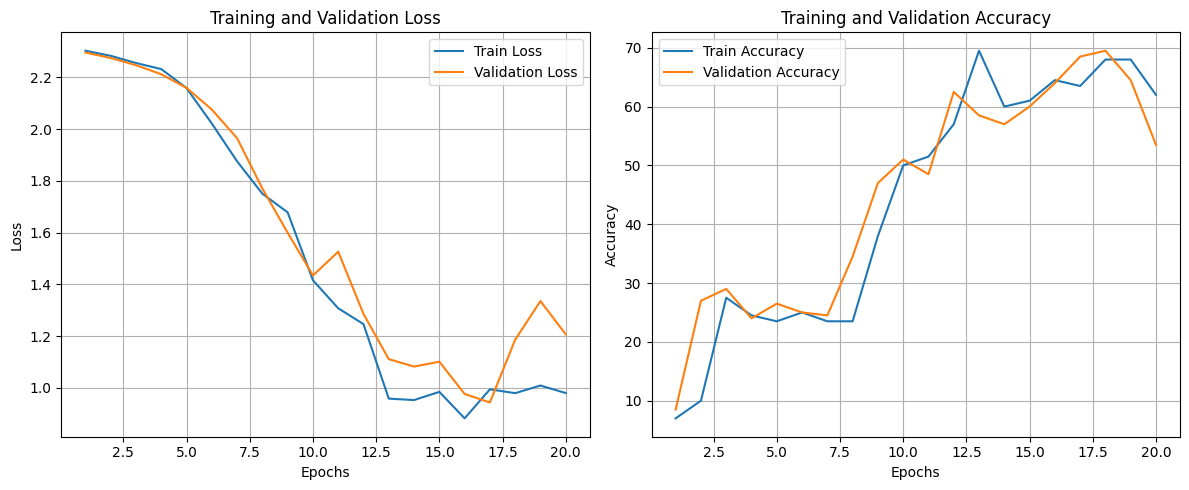

Acurácia da rede na base de teste: 53.50%


In [90]:
model_1 = CNN(
    initialize_weights=False,
    dropout=0.0
)

criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
history_1 = train_model(
    model=model_1,
    trainloader=train_loader,
    valloader=val_loader,
    criterion=criterion_1,
    optimizer=optimizer_1,
    num_epochs=20
)

plot_training_history(history_1)

test_model(model_1, val_loader)

100%|██████████| 4/4 [00:00<00:00, 72.78it/s]


Epoch 1, Train Loss: 2.355, Train Accuracy: 10.00%
Epoch 1, Val Loss: 2.308, Val Accuracy: 14.00%


100%|██████████| 4/4 [00:00<00:00, 72.22it/s]


Epoch 2, Train Loss: 2.294, Train Accuracy: 11.50%
Epoch 2, Val Loss: 2.264, Val Accuracy: 24.50%


100%|██████████| 4/4 [00:00<00:00, 74.81it/s]


Epoch 3, Train Loss: 2.233, Train Accuracy: 19.00%
Epoch 3, Val Loss: 2.217, Val Accuracy: 36.00%


100%|██████████| 4/4 [00:00<00:00, 70.57it/s]


Epoch 4, Train Loss: 2.251, Train Accuracy: 20.00%
Epoch 4, Val Loss: 2.158, Val Accuracy: 39.50%


100%|██████████| 4/4 [00:00<00:00, 71.97it/s]

Epoch 5, Train Loss: 2.084, Train Accuracy: 26.00%


Epoch 5, Val Loss: 2.052, Val Accuracy: 37.50%


100%|██████████| 4/4 [00:00<00:00, 56.82it/s]


Epoch 6, Train Loss: 2.062, Train Accuracy: 28.00%
Epoch 6, Val Loss: 1.882, Val Accuracy: 36.50%


100%|██████████| 4/4 [00:00<00:00, 70.29it/s]

Epoch 7, Train Loss: 1.888, Train Accuracy: 31.50%


Epoch 7, Val Loss: 1.716, Val Accuracy: 39.00%


100%|██████████| 4/4 [00:00<00:00, 65.34it/s]


Epoch 8, Train Loss: 1.675, Train Accuracy: 37.00%
Epoch 8, Val Loss: 1.508, Val Accuracy: 43.50%


100%|██████████| 4/4 [00:00<00:00, 58.17it/s]

Epoch 9, Train Loss: 1.606, Train Accuracy: 45.50%


Epoch 9, Val Loss: 1.352, Val Accuracy: 52.50%


100%|██████████| 4/4 [00:00<00:00, 68.54it/s]


Epoch 10, Train Loss: 1.426, Train Accuracy: 52.00%
Epoch 10, Val Loss: 1.259, Val Accuracy: 54.50%


100%|██████████| 4/4 [00:00<00:00, 38.77it/s]


Epoch 11, Train Loss: 1.209, Train Accuracy: 54.00%
Epoch 11, Val Loss: 1.244, Val Accuracy: 58.00%


100%|██████████| 4/4 [00:00<00:00, 73.89it/s]


Epoch 12, Train Loss: 1.303, Train Accuracy: 50.00%
Epoch 12, Val Loss: 1.210, Val Accuracy: 64.50%


100%|██████████| 4/4 [00:00<00:00, 76.08it/s]


Epoch 13, Train Loss: 1.242, Train Accuracy: 60.00%
Epoch 13, Val Loss: 1.207, Val Accuracy: 61.00%


100%|██████████| 4/4 [00:00<00:00, 71.64it/s]


Epoch 14, Train Loss: 1.475, Train Accuracy: 59.50%
Epoch 14, Val Loss: 1.079, Val Accuracy: 65.00%


100%|██████████| 4/4 [00:00<00:00, 76.39it/s]


Epoch 15, Train Loss: 1.066, Train Accuracy: 62.00%
Epoch 15, Val Loss: 1.076, Val Accuracy: 61.00%


100%|██████████| 4/4 [00:00<00:00, 79.49it/s]


Epoch 16, Train Loss: 1.129, Train Accuracy: 61.00%
Epoch 16, Val Loss: 1.032, Val Accuracy: 64.50%


100%|██████████| 4/4 [00:00<00:00, 66.38it/s]


Epoch 17, Train Loss: 0.968, Train Accuracy: 61.00%
Epoch 17, Val Loss: 0.965, Val Accuracy: 65.00%


100%|██████████| 4/4 [00:00<00:00, 52.17it/s]

Epoch 18, Train Loss: 0.935, Train Accuracy: 61.50%


Epoch 18, Val Loss: 0.921, Val Accuracy: 68.50%


100%|██████████| 4/4 [00:00<00:00, 78.58it/s]

Epoch 19, Train Loss: 0.907, Train Accuracy: 71.50%


Epoch 19, Val Loss: 0.978, Val Accuracy: 67.00%


100%|██████████| 4/4 [00:00<00:00, 71.71it/s]


Epoch 20, Train Loss: 0.930, Train Accuracy: 63.50%
Epoch 20, Val Loss: 0.862, Val Accuracy: 68.00%
Treinamento concluído


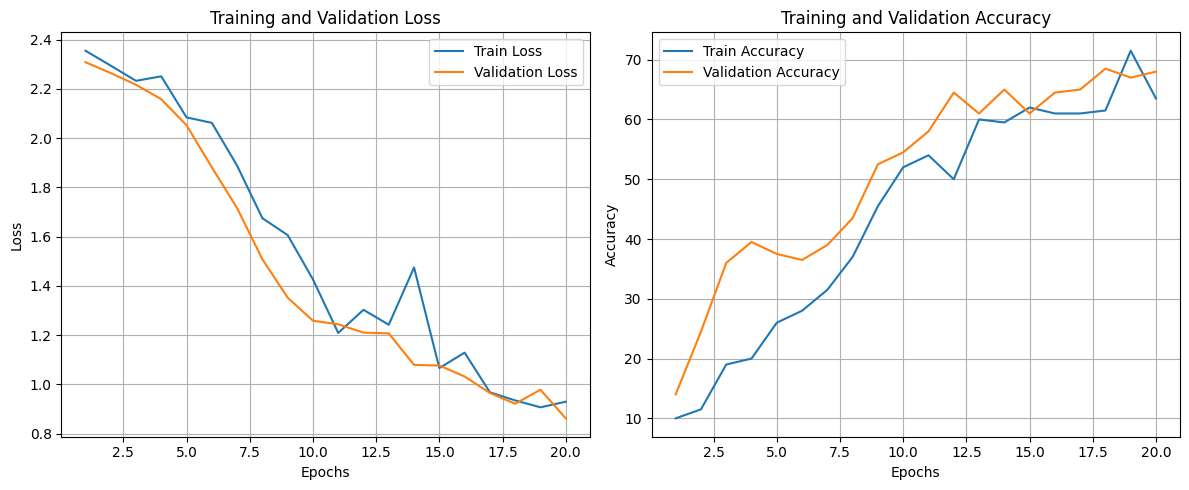

Acurácia da rede na base de teste: 68.00%


In [92]:
model_2 = CNN(
    initialize_weights=True,
    dropout=0.5
)

criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
history_2 = train_model(
    model=model_2,
    trainloader=train_loader,
    valloader=val_loader,
    criterion=criterion_2,
    optimizer=optimizer_2,
    num_epochs=20
)

plot_training_history(history_2)

test_model(model_2, val_loader)

## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [ ]:
# for i in range(5):
#     num_neurons = np.random.randint(10, 100)
#     model = ...
#     criterion = ...
#     optimizer = ...
#     history = ...

#     print(f'Número de neurônios na camada fully connected: {num_neurons}')
#     test_model(model, val_loader)
#     print()